### Recency Frequency Monetary (RFM) Segmentation Model 
* Source blog:https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
* Source data: https://www.kaggle.com/carrie1/ecommerce-data

In [32]:
# Import libraries
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import squarify

In [33]:
# Read dataset
online = pd.read_csv('online_retail.csv', encoding = "ISO-8859-1")
# Convert InvoiceDate from object to datetime format
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

In [34]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [35]:
# check the null values in the dataframe ie. which columns have null values
# Description is not critical to this analysis so ignore null values in this feature
online.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [38]:
# Drop all NA value rows ie of above 135,080 Customer ID from online
online.dropna()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [40]:
# Explore data size, null values, starting & end date times
print('{:,} rows; {:,} columns'
      .format(online.shape[0], online.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(online[online.CustomerID.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(online['InvoiceDate'].min(),
                                    online['InvoiceDate'].max()))

541,909 rows; 8 columns
135,080 transactions don't have a customer id
Transactions timeframe from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


The first we need to do is to sort customers based on recency, frequency, and monetary values. To calculate recency, we will be taking one day after the last invoice date of our data set as the snapshot date ‘2011–12–10 12:50:00’. The date difference will give us how recent the last transaction was made. With that, we can then group our ‘online’ dateframe by customer ID and assign it to ‘data_process’ for our data pre-processing.

In [41]:
# --Group data by customerID--
# Create TotalSum column for online dataset
online['TotalSum'] = online['Quantity'] * online['UnitPrice']
# Create snapshot date
snapshot_date = online['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)
# Grouping by CustomerID
data_process = online.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'})
# Rename the columns of this new data_process dataframe 
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

2011-12-10 12:50:00


Let’s take a look at our progress so far.

In [42]:
# Print top 5 rows and shape of dataframe
print(data_process.head())
print('{:,} rows; {:,} columns'
      .format(data_process.shape[0], data_process.shape[1]))

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           2        182        4310.00
12348.0          75         31        1797.24
12349.0          19         73        1757.55
12350.0         310         17         334.40
4,372 rows; 3 columns


Great, we have 4,372 customer records grouped by recency of their purchase, the frequency by their quantity, and the monetary value of the purchases. Now we can get into the meat of things and use the .qcut() method to assign the relative percentile to their RFM features. But before that, let’s examine the distribution of our Recency, Frequency, and Monetary.

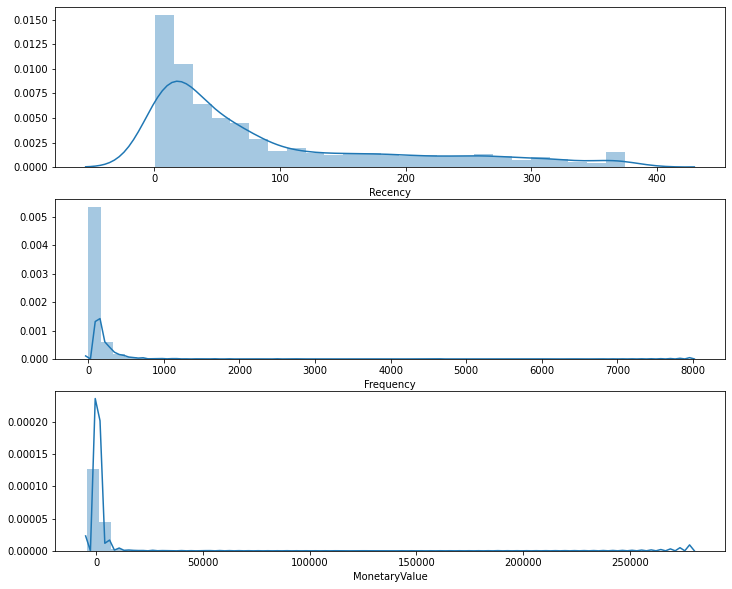

In [44]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of Recency R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of Frequency F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of Monetary M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

This plot provides us with some very interesting insights and how skewed our data is. The important thing to take note here is that we will be grouping these values in quantiles. 

If we were going to segment using say k-Means, we would have to scale our data to center the mean and standard deviations. But we are not segmenting using a model. We are only using the simple calcuations & splitting into groups or ranges based on the above distribution. 

We will create following binning ie. cut into groups & give them segment number labels:
* R: 4 range labels ie. 4,3,2 & 1 based on descending order of how recent last puchase was from today. 
* F: 4 range labels from 1,2,3 & 4 based on total number of transactions
* M: we will sum all the transaction based on above R & F segments

We will use the .qcut() method of pandas to cut the data into these ranges & label them for our RFM analysis. We create a 4 labels for our f_labels, where 4 is the “best” quantile. We do the same for our f_label. We then create new columns “R” and “F” and assign the r_group and f_group values to them respectively.

#### Special note on pandas qcut() method
#### pd.qcut()
Qcut (quantile-cut) differs from cut in the sense that, in qcut, the number of elements in each bin will be roughly the same, but this will come at the cost of differently sized interval widths. On the other hand, in cut, the bin edges were equal sized (when we specified bins=3) with uneven number of elements in each bin or group. Also, cut is useful when you know for sure the interval ranges and the bins, 

For exmaple, if binning an ‘age’ column, we know infants are between 0 and 1 years old, 1-12 years are kids, 13-19 are teenagers, 20-60 are working class grownups, and 60+ senior citizens. So we can appropriately set bins=[0, 1, 12, 19, 60, 140] and labels=[‘infant’, ‘kid’, ‘teenager’, ‘grownup’, ‘senior citizen’]. 

In qcut, when we specify q=5, we are telling pandas to cut the Year column into 5 equal quantiles, i.e. 0-20%, 20-40%, 40-60%, 60-80% and 80-100% buckets/bins.

In [45]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups of R
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)

# Assign these labels to 4 equal percentile groups of F
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)

# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F
CustomerID,,,,,
12346.0,326,2,0.00,1,1
12347.0,2,182,4310.00,4,4
12348.0,75,31,1797.24,2,2
12349.0,19,73,1757.55,3,3
12350.0,310,17,334.40,1,1


Next, we do the same for our monetary value by grouping the values into 4 quantiles using .qcut() method.

In [13]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

Finally, with these 3 scores in place, R, F, and M, we can create our first RFM segment by concatenating the values together below. Let’s assign our data_process dataframe to our newly created rfm dataframe.

In [14]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0
12347.0,2,182,4310.00,4,4,4,4.04.04.0
12348.0,75,31,1797.24,2,2,4,2.02.04.0
12349.0,19,73,1757.55,3,3,4,3.03.04.0
12350.0,310,17,334.40,1,1,2,1.01.02.0


From the output, you can see that we have our concatenated segments ready to be used for our segmentation, but wait, there is one issue…

In [15]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

62


Having 62 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments.

#### Summing the Score
One of the most straightforward methods is to sum our scores to a single number and define RFM levels for each score range.

In [16]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

CustomerID
12346.0     3
12347.0    12
12348.0     8
12349.0    10
12350.0     4
Name: RFM_Score, dtype: int64


We can get creative and hypothesize about what each score range entails, but for this exercise I will take inspiration from some common segment names.

In [17]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0,3,Require Activation
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12,Can't Loose Them
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8,Champions
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10,Can't Loose Them
12350.0,310,17,334.40,1,1,2,1.01.02.0,4,Needs Attention


Finally, we can then group our customers by their RFM level.

In [18]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Can't Loose Them      25.2     195.1        4130.3  1690
Champions             62.7      57.0         974.7   467
Loyal                 78.8      39.7         724.2   447
Needs Attention      174.5      13.9         227.1   391
Potential             94.3      28.5         491.8   468
Promising            153.0      21.2         346.8   517
Require Activation   264.8       7.8         109.1   392


From here, we can see that a large percentage (~60%) of our customers are in the top tier RFM levels. The store must be doing something right to be maintaining their loyalty!

The other 40% will need some work. Let’s explore using some ads to re-target them:
1. Potential — high potential to enter our loyal customer segments, why not throw in some freebies on their next purchase to show that you value them!
2. Promising — showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.
3. Needs Attention — made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.
4. Require Activation — Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.

But before we end, let’s create a nice visualization for our data.

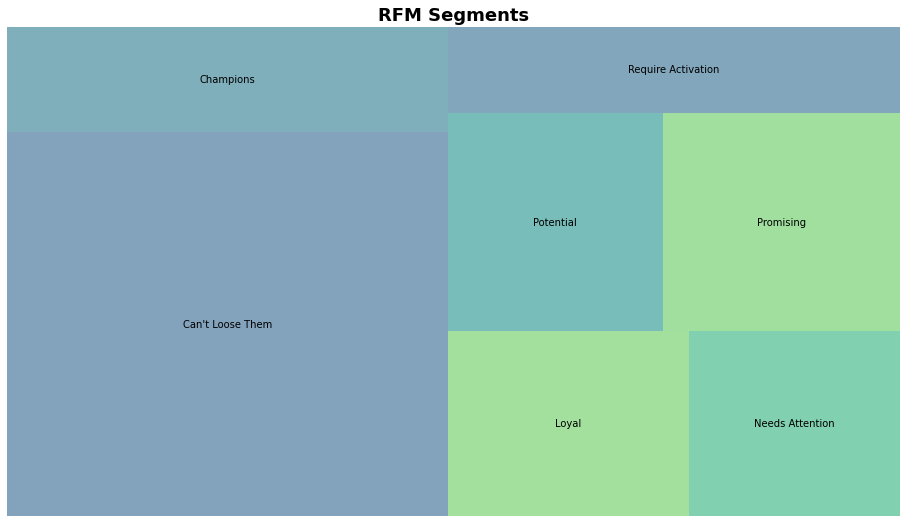

In [19]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()